# Online reconstruction of pMRI data

In this notebook we study online reconstruction algorithm for pMRI data.
Dependecies:
- this repository
- pysap-mri
- pysap
- modopt
and their dependencies
## Introduction

Typically, MRI reconstruction is done entirely after the full acquisition of the k-space data (so-called offline reconstruction)
During the acquisition sequence of MRI can be very long, and this dead time can be used to start the reconstruction.
### Offline vs Online

In the context of pMRI the problem is stated as follows for an (calibrationless) offline reconstruction
$$
\hat{x} = \arg\min \|\Omega \mathcal{F}x - y \| + g(\Psi x) \tag{Problem 1}
$$

where: 
- $\mathcal{F}$ is the fourier transform operator 
- $\Omega$ is the sampling mask, representing the acquisition by the MRI
- $y$ is the completly observed data in kspace.
- $\Psi$ is a sparsifying transform (typically a Wavelet transform)
- $g$ is a proximable regularisation operator ($\ell_1$, groupLasso, OWL...)

Solving this problem is done by using an iterative algorithm relying on convex Optimisation and gradient descent (Condat-Vu, POGM, FISTA...) 


In an online framework Problem 1 is solved during the acquisition, and data is feeded into the iterative algorithm incrementally. Each time, a new estimate of $x$ is given by the algorithm and use as an initial guess for the next step.

$$
\hat{x}_k = \arg\min \|\Omega_k \mathcal{F}x - y_k \| + g(\Psi x) \tag{Problem 2}
$$

Now, the estimate, the observed Data and the mask all depends on the step $k$ of the acquisition.

### Timing Consideration

% TODO the batch trick and timing of MRI sequence

## Setup 

- This notebook rely on the python packages modopt, pysap, pysap-mri and their dependences.
- As a toy model, let's consider a 2D pMRI acquisition with 16 channels where the k-space ( of size 640 x 320) is sampled along 80 columns.

In [55]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO

from online.generator import KspaceGenerator, Column2DKspaceGenerator
from online.reconstructor import OnlineCalibrationlessReconstructor

from utils import implot, load_data
from online.metrics import crop_center_square

In [56]:
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = 1
results = dict()

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


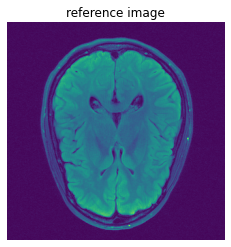

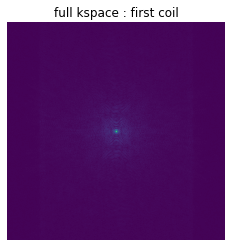

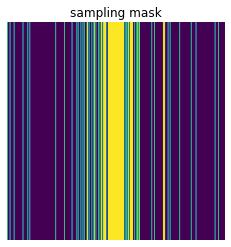

In [57]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
full_k = sp.fft.fftshift(sp.fft.fft2(real_img,norm="ortho"))
final_mask = crop_center_square(final_mask)
implot(real_img, "reference image")
implot(np.sqrt(np.abs(full_k)), "full kspace : first coil")
implot(final_mask, "sampling mask")


## Kspace Acquisition Emulation

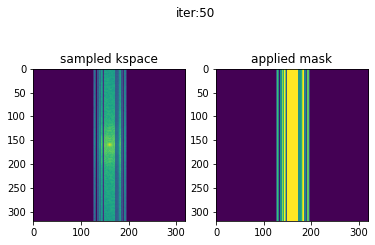

In [58]:
final_k = full_k * final_mask[np.newaxis, ...] # final kspace reacher after all available sampling
kspace_gen = Column2DKspaceGenerator(final_k, mask_loc,max_iter=50)
fig,axs = plt.subplots(1,2)
axs[0].set_title("sampled kspace")
axs[1].set_title("applied mask")

# warning , the animation take some time....
for iteration, (kspace, mask) in enumerate(kspace_gen):
    fig.suptitle(f"iter:{iteration}")
    axs[0].imshow(np.log(np.abs(kspace)+1e-10))
    axs[1].imshow(mask)
    #fig.canvas.draw()


## Operator definition
The pysap API allow us to create high level operator object, that will be combined to perforn the reconstruction.

In [59]:
kspace_gen = Column2DKspaceGenerator(final_k, mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if kspace.ndim == 3 else 1
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(mask=kspace_gen.mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)

# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(kspace))

# Regularizer definition 
GL_op = GroupLASSO(weights=1e-3)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)

## Metrics 

The online reconstruction process can be track with various metrics:
 - PNSR
 - SSIM
 - Relative residual, where the current estimate is compare with the current observable data
     $$ f(x_k) = \frac12\| \Omega_k \mathcal{F} x_k - y_k \|_2^2 + g(\Psi x_k) $$
 - Absolute residual, where the current estimate is compare with the final observable data.
     $$ f(x_k) = \frac12\| \Omega_f \mathcal{F} x_k - y_f \|_2^2 + g(\Psi x_k) $$
In the case of offline reconstruction relative and absolute residual are the same. Furthermore, The relative residual may have a different starting point, but will in the end converge to the same value obtain for the absolute residual.

In the case of pMRI, the calibrationless reconstruction produce an image for every coil of the system. These images are combined into a square root of sum squared (ssos).

In [60]:
from online.metrics import psnr_ssos, ssim_ssos, ssos
from mri.operators import GradAnalysis, GradSynthesis
from mri.optimizers.utils.cost import GenericCost

## Basic Reconstruction  
The online paradigm is agnostic to the considered problem or the iterative algorithm.
Typically, all gradient-descent based algorithm can be easily adapted to an online paradigm,
simply by updating the observed data at each step before running a new step of the algorithm.

### Condat Vu Algorithm + GL regularisation

In [61]:
prox_op = GL_op
cost_op_kwargs={'cost_interval':1}
solver = OnlineCalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="analysis",
        lipschitz_cst =1.1,
        verbose=0)

# mockup operator to compare with offline
constant_fourier_op = copy.deepcopy(fourier_op)
constant_grad_ana = GradAnalysis(constant_fourier_op,lipschitz_cst=1.1)
constant_grad_ana._obs_data = final_k
constant_grad_ana.fourier_op.mask = final_mask

def offline_cost(x,y):
    return constant_grad_ana.cost(x) + prox_op.cost(y)
def data_cost(x):
    return constant_grad_ana.cost(x)

metrics = {'psnr': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'early_stopping': False,
                    'cst_kwargs': {'ref': real_img},
                    },
           'ssim': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'cst_kwargs': {'ref': real_img},
                    'early_stopping': False,
                    },
           'abs_res': {'metric': offline_cost,
                       'mapping': {'x_new': 'x',
                                   'y_new': 'y'},
                       'cst_kwargs': dict(),
                       'early_stopping': False,
                       },
           'data_res': {'metric': data_cost,
                       'mapping': {'x_new': 'x'},
                       'cst_kwargs': {},
                       'early_stopping': False,
                       },
           }

xf_condat, cost, metric_results_condatvu= solver.reconstruct(kspace_generator=kspace_gen,
                  optimization_alg='condatvu',
                  cost_op_kwargs=cost_op_kwargs,
                  metrics=metrics,
                  metric_call_period=1)


metric_results_condatvu['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}

results['condat'] = {
    'xf': xf_condat,
    'metrics': metric_results_condatvu
}

81it [00:07, 11.25it/s]                        


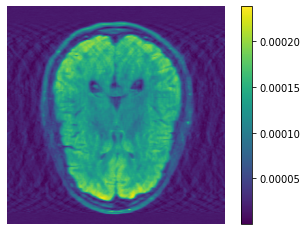

In [62]:
implot(ssos(xf_condat),colorbar=True)

Text(0.5, 0, 'iterations')

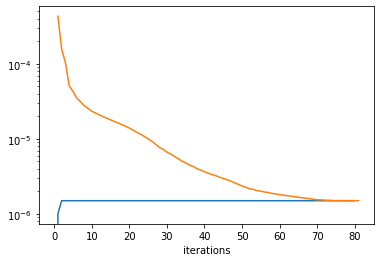

In [63]:
plt.figure()
plt.semilogy(cost, label="relative cost")
plt.semilogy(metric_results_condatvu['abs_res']['index'],metric_results_condatvu['abs_res']['values'],label='absolute cost')
plt.xlabel('iterations')

### POGM + GL


In [64]:
kspace_gen = Column2DKspaceGenerator(final_k, mask_loc)
prox_op=GL_op
# The fourier Operator apply also the sampling mask.
cost_op_kwargs={'cost_interval':1}
solver2 = OnlineCalibrationlessReconstructor(
        fourier_op,
        linear_op=linear_op,
        regularizer_op=prox_op,
        gradient_formulation="synthesis",
        lipschitz_cst =1.1,
        verbose=0)

# mockup operator to compare with offline
constant_fourier_op = copy.deepcopy(fourier_op)
constant_grad_syn = GradSynthesis(linear_op,constant_fourier_op,lipschitz_cst=1.1)
constant_grad_syn._obs_data = final_k
constant_grad_syn.fourier_op.mask = final_mask


def data_cost_syn(x):
    x = linear_op.op(x)
    return constant_grad_syn.cost(x)
def offline_cost_syn(x):
    x = linear_op.op(x) # TODO: PR to pysap mri to remove the adj_op in the call to signal of POGM
    return constant_grad_syn.cost(x) + prox_op.cost(x)

metrics = {'psnr': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'early_stopping': False,
                    'cst_kwargs': {'ref': real_img},
                    },
           'ssim': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'cst_kwargs': {'ref': real_img},
                    'early_stopping': False,
                    },
           'abs_res': {'metric': offline_cost_syn,
                       'mapping': {'x_new': 'x'},
                       'cst_kwargs': {},
                       'early_stopping': False,
                       },
           'data_res': {'metric': data_cost_syn,
                       'mapping': {'x_new': 'x'},
                       'cst_kwargs': {},
                       'early_stopping': False,
                       },
           }
xf_pogm, cost, metric_results_pogm = solver2.reconstruct(kspace_generator=kspace_gen,
                  optimization_alg='pogm',
                  cost_op_kwargs=cost_op_kwargs,
                  metrics=metrics,
                  metric_call_period=1)

metric_results_pogm['cost'] = {'index':np.arange(0,len(cost),cost_op_kwargs['cost_interval']),
                          'values':np.array(cost)}

results['pogm'] = {
    'xf': xf_pogm,
    'metrics': metric_results_pogm
}

81it [00:15,  5.31it/s]                        


Text(0.5, 0, 'iterations')

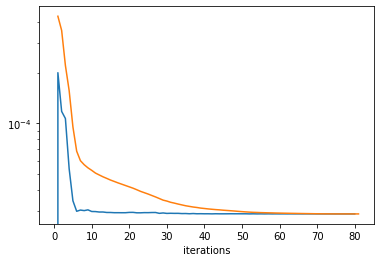

In [65]:

plt.figure()
plt.semilogy(cost, label="relative cost")
plt.semilogy(metric_results_pogm['abs_res']['index'],metric_results_pogm['abs_res']['values'],label='absolute cost')
plt.xlabel('iterations')


## Partial Gradient Update

In [66]:
DATA_DIR = "data/"
N_JOBS = 1
import numpy as np
import scipy as sp
import copy
import matplotlib.pyplot  as plt
from mri.operators import FFT, WaveletN, OWL
from mri.operators import GradAnalysis
from modopt.opt.proximity import GroupLASSO
from online.generator import PartialColumn2DKspaceGenerator

from online.metrics import crop_center_square, psnr_ssos, ssim_ssos, ssos
from utils import implot, load_data
from tqdm import tqdm

In [67]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
full_k = sp.fft.fftshift(sp.fft.fft2(real_img,norm="ortho"))

final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask
partial_kspace = PartialColumn2DKspaceGenerator(final_k, mask_loc,max_iter=79)
K_DIM = partial_kspace.shape[1:]
N_COILS = 1

# The fourier Operator apply also the sampling mask.
fourier_op = FFT(mask=partial_kspace.mask,
                 shape=K_DIM,
                 n_coils=N_COILS,
                 n_jobs=N_JOBS)

# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
print("dim",final_k.ndim)
linear_op.op(final_k)

# Regularizer definition
GL_op = GroupLASSO(weights=1e-5)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)

(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1
dim 2


In [68]:
# mockup operator to compare with offline
constant_fourier_op = copy.deepcopy(fourier_op)
constant_grad_ana = GradAnalysis(constant_fourier_op,lipschitz_cst=1.1)
constant_grad_ana._obs_data = final_k
constant_grad_ana.fourier_op.mask = final_mask
def data_cost(x):
    return constant_grad_ana.cost(x)


custom_grad = GradAnalysis(fourier_op,lipschitz_cst=1.1)

metrics = {'psnr': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'early_stopping': False,
                    'cst_kwargs': {'ref': real_img},
                    },
           'ssim': {'metric': psnr_ssos,
                    'mapping': {'x_new': 'test'},
                    'cst_kwargs': {'ref': real_img},
                    'early_stopping': False,
                    },
           'data_res': {'metric': lambda x,y : data_cost(x),
                       'mapping': {'x_new': 'x'},
                       'cst_kwargs': {},
                       'early_stopping': False,
                    },
           }

In [69]:
x_old = np.zeros_like(final_k)
s = np.zeros_like(final_k)
gamma = 1
partial_kspace.reset()
metrics_results = {k:{'values':[]} for k in metrics.keys()}
for delta_y, mask in tqdm(partial_kspace):
    # compute gradient term:
    custom_grad._obs_data = delta_y
    custom_grad.fourier_op.mask = mask
    custom_grad.get_grad(x_old)
    s = custom_grad.grad# sum update
    x_new = linear_op.adj_op(GL_op.op(linear_op.op( x_old - gamma * s))) # regularisation in wavelet domain
    x_old = x_new.copy()
    # custom metrics handling
    for k in metrics:
        metrics_results[k]['values'].append(metrics[k]['metric'](x_new,real_img))

100%|██████████| 79/79 [00:05<00:00, 13.77it/s]


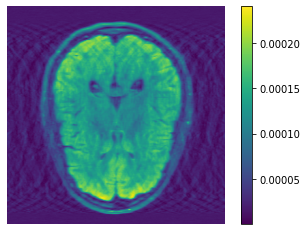

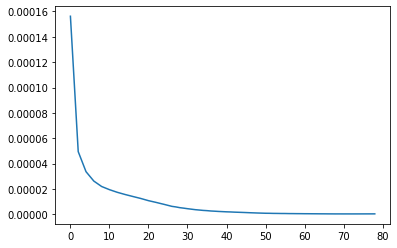

In [70]:
implot(ssos(x_new), colorbar=True)
xf_saga = x_new.copy()

results['saga'] = {
    'xf': xf_saga,
    'metrics': metrics_results,
}
plt.plot(results['saga']['metrics']['data_res']['values'])

## Compare methods

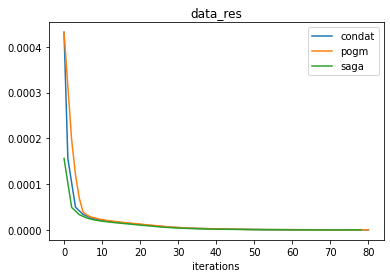

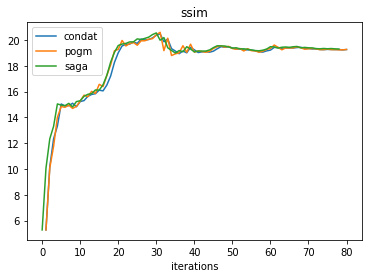

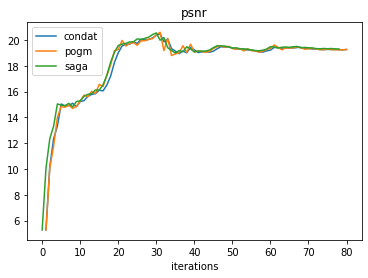

In [71]:
for metric in ['data_res','ssim','psnr']:
    plt.figure()
    plt.title(metric)
    plt.xlabel("iterations")
    for alg in ['condat','pogm','saga']:
        plt.plot(results[alg]['metrics'][metric]['values'],label=alg)
    plt.legend()